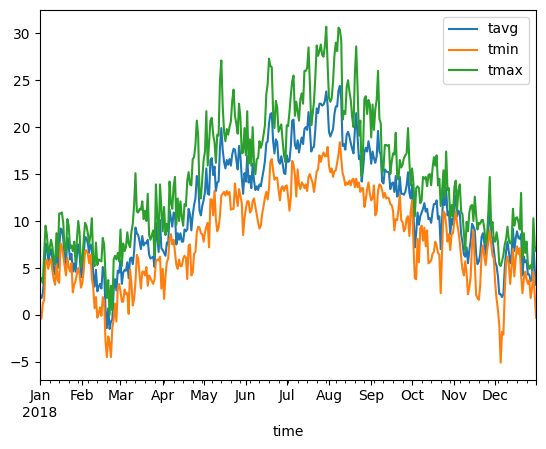

In [2]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Create Point for Vancouver, BC
vancouver = Point(49.2497, -123.1193, 70)

# Get daily data for 2018
data = Daily(vancouver, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()


In [3]:
data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2018-01-01,1.8,-0.4,4.0,0.0,0.0,<NA>,8.7,0.0,1030.7,<NA>
2018-01-02,1.8,-0.4,3.9,0.0,0.0,<NA>,7.1,0.0,1028.5,<NA>
2018-01-03,2.3,1.2,3.4,0.0,<NA>,<NA>,6.8,0.0,1022.5,<NA>
2018-01-04,4.1,1.6,6.6,0.0,<NA>,<NA>,6.1,0.0,1016.7,<NA>
2018-01-05,7.6,5.7,9.5,30.4,0.0,<NA>,10.0,0.0,1014.5,<NA>
...,...,...,...,...,...,...,...,...,...,...
2018-12-27,3.6,1.8,5.3,0.0,0.0,<NA>,7.2,<NA>,1027.8,<NA>
2018-12-28,3.8,2.8,4.8,24.5,0.0,<NA>,17.6,<NA>,1025.2,<NA>
2018-12-29,7.5,4.6,10.3,16.6,<NA>,<NA>,25.3,58.0,1013.7,<NA>


In [4]:
import json
with open('../Weather/full.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

REGION_CODES = ["TN", "AP", "KA", "KL"]
result = []
for item in data:
    if item['country'] == "IN" and item['region'] in REGION_CODES and item['inventory']['hourly']['start']:
        result.append(item)

with open('../Weather/india_south.json', 'w') as f:
    json.dump(result, f, indent=4)



In [5]:
LOCATIONS = {'Chennai': ['43278', '43279', '43277', '43275'], 
             'Secunderabad': ['43128', 'VOHS0', '43083', '43133'], 
             'Cochin': ['43353', 'VOCI0'], 
             'Bangalore': ['43295', '43296', 'VOBL0', '43272'], 
             'Vijaywada': ['43181'], 
             'Sricity': ['VOTP0', '43275', '43277', '43303']}

In [6]:
# Import required libraries for weather data processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from meteostat import Hourly
import warnings
warnings.filterwarnings('ignore')

# Set date range for data fetching
start_date = datetime(2019, 4, 1)
end_date = datetime(2025, 10, 1)

print(f"Processing weather data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Total locations to process: {len(LOCATIONS)}")


Processing weather data from 2019-04-01 to 2025-10-01
Total locations to process: 6


In [7]:
# Create output directories
output_dir = '../outputs/processed_weather_data'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created: {output_dir}")


Output directory created: ../outputs/processed_weather_data


In [10]:
def fetch_location_weather_data(location_name, station_ids, start_date, end_date):
    """
    Fetch hourly weather data for a location using multiple station IDs.
    Uses the station with most complete data as primary source.
    Averages values when multiple stations have data for the same hour.
    """
    print(f"\nProcessing {location_name} with stations: {station_ids}")
    
    all_station_data = []
    station_completeness = {}
    
    # Fetch data from each station
    for station_id in station_ids:
        try:
            print(f"  Fetching data from station {station_id}...")
            data = Hourly(station_id, start_date, end_date)
            df = data.fetch()
            
            if df is not None and not df.empty:
                # Check what columns are available
                available_cols = df.columns.tolist()
                print(f"    Station {station_id} columns: {available_cols}")
                
                df['station_id'] = station_id
                df['location'] = location_name
                all_station_data.append(df)
                
                # Calculate data completeness using any available temperature column
                total_hours = len(pd.date_range(start_date, end_date, freq='H'))
                
                # Try different temperature columns for completeness calculation
                temp_cols = ['tavg', 'tmin', 'tmax']
                completeness_col = None
                for col in temp_cols:
                    if col in df.columns:
                        completeness_col = col
                        break
                
                if completeness_col:
                    available_hours = len(df.dropna(subset=[completeness_col]))
                    completeness = (available_hours / total_hours) * 100
                else:
                    # If no temperature columns, use any numeric column
                    numeric_cols = df.select_dtypes(include=[np.number]).columns
                    if len(numeric_cols) > 0:
                        available_hours = len(df.dropna(subset=[numeric_cols[0]]))
                        completeness = (available_hours / total_hours) * 100
                    else:
                        completeness = 0
                
                station_completeness[station_id] = completeness
                print(f"    Station {station_id}: {completeness:.1f}% data completeness")
            else:
                print(f"    Station {station_id}: No data available")
                
        except Exception as e:
            print(f"    Error fetching data from station {station_id}: {str(e)}")
            continue
    
    if not all_station_data:
        print(f"  No data available for {location_name}")
        return None
    
    # Find the station with most complete data
    if station_completeness:
        primary_station = max(station_completeness, key=station_completeness.get)
        print(f"  Primary station: {primary_station} ({station_completeness[primary_station]:.1f}% complete)")
    else:
        print(f"  No station completeness data available for {location_name}")
        return None
    
    # For now, let's use a simpler approach - just use the primary station's data
    # This avoids the complex averaging logic that was causing issues
    if all_station_data:
        # Find the primary station data
        primary_station_id = max(station_completeness, key=station_completeness.get)
        primary_data = None
        for station_data in all_station_data:
            if station_data['station_id'].iloc[0] == primary_station_id:
                primary_data = station_data.copy()
                break
        
        if primary_data is not None:
            # Clean up the data
            result_df = primary_data.drop(['station_id', 'location'], axis=1, errors='ignore')
            print(f"  Using data from primary station {primary_station_id}: {len(result_df)} hours")
            return result_df
        else:
            # Fallback to first available station
            result_df = all_station_data[0].copy()
            result_df = result_df.drop(['station_id', 'location'], axis=1, errors='ignore')
            print(f"  Using data from first available station: {len(result_df)} hours")
            return result_df
    else:
        print(f"  No station data available for {location_name}")
        return None


In [11]:
# Process all locations and fetch hourly data
all_location_data = {}
failed_locations = []

print("=" * 60)
print("FETCHING HOURLY DATA FOR ALL LOCATIONS")
print("=" * 60)

for location_name, station_ids in LOCATIONS.items():
    try:
        location_data = fetch_location_weather_data(location_name, station_ids, start_date, end_date)
        
        if location_data is not None:
            all_location_data[location_name] = location_data
            print(f"✓ Successfully processed {location_name}")
        else:
            failed_locations.append(location_name)
            print(f"✗ Failed to process {location_name}")
            
    except Exception as e:
        print(f"✗ Error processing {location_name}: {str(e)}")
        failed_locations.append(location_name)

print(f"\nSummary: {len(all_location_data)} locations processed successfully")
if failed_locations:
    print(f"Failed locations: {failed_locations}")


FETCHING HOURLY DATA FOR ALL LOCATIONS

Processing Chennai with stations: ['43278', '43279', '43277', '43275']
  Fetching data from station 43278...
    Station 43278 columns: ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
    Station 43278: 79.1% data completeness
  Fetching data from station 43279...
    Station 43279 columns: ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
    Station 43279: 100.0% data completeness
  Fetching data from station 43277...
    Station 43277 columns: ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
    Station 43277: 67.4% data completeness
  Fetching data from station 43275...
    Station 43275 columns: ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
    Station 43275: 77.9% data completeness
  Primary station: 43279 (100.0% complete)
  Using data from primary station 43279: 57001 hours
✓ Su

In [12]:
def calculate_monthly_statistics(hourly_data, location_name):
    """
    Calculate monthly Min, Max, and Average for all weather metrics.
    """
    print(f"\nCalculating monthly statistics for {location_name}...")
    
    # Create a copy to avoid modifying original data
    df = hourly_data.copy()
    
    # Add year-month column for grouping
    df['year_month'] = df.index.to_period('M')
    
    # Define all weather metrics to process
    weather_metrics = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
    
    # Filter to only include metrics that exist in the data
    available_metrics = [col for col in weather_metrics if col in df.columns]
    print(f"  Available metrics: {available_metrics}")
    
    monthly_stats = []
    
    for year_month in df['year_month'].unique():
        month_data = df[df['year_month'] == year_month]
        
        stats = {
            'location': location_name,
            'year': year_month.year,
            'month': year_month.month,
            'year_month': str(year_month)
        }
        
        # Calculate Min, Max, Avg for each metric
        for metric in available_metrics:
            if metric in month_data.columns:
                values = month_data[metric].dropna()
                if not values.empty:
                    stats[f'{metric}_min'] = values.min()
                    stats[f'{metric}_max'] = values.max()
                    stats[f'{metric}_avg'] = values.mean()
                else:
                    stats[f'{metric}_min'] = np.nan
                    stats[f'{metric}_max'] = np.nan
                    stats[f'{metric}_avg'] = np.nan
        
        monthly_stats.append(stats)
    
    monthly_df = pd.DataFrame(monthly_stats)
    monthly_df.set_index(['location', 'year', 'month'], inplace=True)
    
    print(f"  Generated {len(monthly_df)} monthly records")
    return monthly_df


In [13]:
# Calculate monthly statistics for all locations
print("=" * 60)
print("CALCULATING MONTHLY STATISTICS")
print("=" * 60)

all_monthly_stats = []
all_hourly_data = {}

for location_name, hourly_data in all_location_data.items():
    try:
        # Calculate monthly statistics
        monthly_stats = calculate_monthly_statistics(hourly_data, location_name)
        all_monthly_stats.append(monthly_stats)
        all_hourly_data[location_name] = hourly_data
        
        print(f"✓ Monthly stats calculated for {location_name}")
        
    except Exception as e:
        print(f"✗ Error calculating monthly stats for {location_name}: {str(e)}")

# Combine all monthly statistics
if all_monthly_stats:
    combined_monthly_stats = pd.concat(all_monthly_stats)
    print(f"\nCombined monthly statistics: {len(combined_monthly_stats)} records")
else:
    print("\nNo monthly statistics generated")
    combined_monthly_stats = pd.DataFrame()


CALCULATING MONTHLY STATISTICS

Calculating monthly statistics for Chennai...
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Generated 79 monthly records
✓ Monthly stats calculated for Chennai

Calculating monthly statistics for Secunderabad...
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Generated 79 monthly records
✓ Monthly stats calculated for Secunderabad

Calculating monthly statistics for Cochin...
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Generated 70 monthly records
✓ Monthly stats calculated for Cochin

Calculating monthly statistics for Bangalore...
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Generated 79 monthly records
✓ Monthly stats calculated for Bangalore

Calculating monthly statistics for Vijaywada...
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Generated 79 monthly records
✓ Monthly stats calculated for Vijaywada

Calculating month

In [ ]:
# Save results to CSV files
print("=" * 60)
print("SAVING RESULTS")
print("=" * 60)

# Save individual hourly data files
for location_name, hourly_data in all_hourly_data.items():
    try:
        hourly_file = f"{output_dir}/{location_name}_hourly.csv"
        hourly_data.to_csv(hourly_file)
        print(f" {hourly_file}")
    except Exception as e:
        print(f"✗ Error saving hourly data for {location_name}: {str(e)}")

# Save individual monthly stats files
for location_name, monthly_data in zip(all_location_data.keys(), all_monthly_stats):
    try:
        monthly_file = f"{output_dir}/{location_name}_monthly_stats.csv"
        monthly_data.to_csv(monthly_file)
        print(f"✓ Saved monthly stats: {monthly_file}")
    except Exception as e:
        print(f"✗ Error saving monthly stats for {location_name}: {str(e)}")

# Save combined monthly stats
if not combined_monthly_stats.empty:
    try:
        combined_file = f"{output_dir}/all_locations_monthly_stats.csv"
        combined_monthly_stats.to_csv(combined_file)
        print(f"✓ Saved combined monthly stats: {combined_file}")
    except Exception as e:
        print(f"✗ Error saving combined monthly stats: {str(e)}")

print(f"\nAll files saved to: {output_dir}")


SAVING RESULTS
✓ Saved hourly data: ../outputs/processed_weather_data/Chennai_hourly.csv
✓ Saved hourly data: ../outputs/processed_weather_data/Secunderabad_hourly.csv
✓ Saved hourly data: ../outputs/processed_weather_data/Cochin_hourly.csv
✓ Saved hourly data: ../outputs/processed_weather_data/Bangalore_hourly.csv
✓ Saved hourly data: ../outputs/processed_weather_data/Vijaywada_hourly.csv
✓ Saved hourly data: ../outputs/processed_weather_data/Sricity_hourly.csv
✓ Saved monthly stats: ../outputs/processed_weather_data/Chennai_monthly_stats.csv
✓ Saved monthly stats: ../outputs/processed_weather_data/Secunderabad_monthly_stats.csv
✓ Saved monthly stats: ../outputs/processed_weather_data/Cochin_monthly_stats.csv
✓ Saved monthly stats: ../outputs/processed_weather_data/Bangalore_monthly_stats.csv
✓ Saved monthly stats: ../outputs/processed_weather_data/Vijaywada_monthly_stats.csv
✓ Saved monthly stats: ../outputs/processed_weather_data/Sricity_monthly_stats.csv
✓ Saved combined monthly st

In [15]:
# Display summary statistics and data completeness
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

for location_name, hourly_data in all_hourly_data.items():
    print(f"\n{location_name}:")
    print(f"  Total hours of data: {len(hourly_data)}")
    
    # Calculate data completeness for each metric
    total_hours = len(pd.date_range(start_date, end_date, freq='H'))
    completeness = (len(hourly_data) / total_hours) * 100
    print(f"  Data completeness: {completeness:.1f}%")
    
    # Show available metrics
    available_cols = [col for col in ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco'] 
                     if col in hourly_data.columns]
    print(f"  Available metrics: {available_cols}")
    
    # Show date range
    if not hourly_data.empty:
        print(f"  Date range: {hourly_data.index.min()} to {hourly_data.index.max()}")

# Display sample of monthly statistics
if not combined_monthly_stats.empty:
    print(f"\nSample of monthly statistics:")
    print(combined_monthly_stats.head(10))
    
    print(f"\nMonthly statistics shape: {combined_monthly_stats.shape}")
    print(f"Locations: {combined_monthly_stats.index.get_level_values('location').unique()}")
    print(f"Date range: {combined_monthly_stats.index.get_level_values('year').min()}-{combined_monthly_stats.index.get_level_values('month').min()} to {combined_monthly_stats.index.get_level_values('year').max()}-{combined_monthly_stats.index.get_level_values('month').max()}")


SUMMARY STATISTICS

Chennai:
  Total hours of data: 57001
  Data completeness: 100.0%
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Date range: 2019-04-01 00:00:00 to 2025-10-01 00:00:00

Secunderabad:
  Total hours of data: 56355
  Data completeness: 98.9%
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Date range: 2019-04-01 00:00:00 to 2025-10-01 00:00:00

Cochin:
  Total hours of data: 49514
  Data completeness: 86.9%
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Date range: 2020-01-14 10:00:00 to 2025-10-01 00:00:00

Bangalore:
  Total hours of data: 56928
  Data completeness: 99.9%
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Date range: 2019-04-01 00:00:00 to 2025-10-01 00:00:00

Vijaywada:
  Total hours of data: 53361
  Data completeness: 93.6%
  Available metrics: ['prcp', 'wspd', 'wdir', 'pres', 'tsun', 'coco']
  Date range: 2019-04-01 00:00:00 to 2025-10-01 00:00:00

Sricit

In [ ]:
# Create sample visualizations
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("CREATING SAMPLE VISUALIZATIONS")
print("=" * 60)

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with subplots for temperature trends
if not combined_monthly_stats.empty and 'tavg_avg' in combined_monthly_stats.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Monthly Weather Trends by Location', fontsize=16)
    
    # Plot 1: Average Temperature Trends
    ax1 = axes[0, 0]
    for location in combined_monthly_stats.index.get_level_values('location').unique():
        location_data = combined_monthly_stats.loc[location]
        if 'tavg_avg' in location_data.columns:
            ax1.plot(range(len(location_data)), location_data['tavg_avg'], 
                    label=location, marker='o', markersize=3)
    ax1.set_title('Average Temperature Trends')
    ax1.set_xlabel('Month Index')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Temperature Range (Max - Min)
    ax2 = axes[0, 1]
    for location in combined_monthly_stats.index.get_level_values('location').unique():
        location_data = combined_monthly_stats.loc[location]
        if 'tmax_avg' in location_data.columns and 'tmin_avg' in location_data.columns:
            temp_range = location_data['tmax_avg'] - location_data['tmin_avg']
            ax2.plot(range(len(location_data)), temp_range, 
                    label=location, marker='s', markersize=3)
    ax2.set_title('Temperature Range (Max - Min)')
    ax2.set_xlabel('Month Index')
    ax2.set_ylabel('Temperature Range (°C)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Precipitation Trends
    ax3 = axes[1, 0]
    for location in combined_monthly_stats.index.get_level_values('location').unique():
        location_data = combined_monthly_stats.loc[location]
        if 'prcp_avg' in location_data.columns:
            ax3.plot(range(len(location_data)), location_data['prcp_avg'], 
                    label=location, marker='^', markersize=3)
    ax3.set_title('Average Precipitation Trends')
    ax3.set_xlabel('Month Index')
    ax3.set_ylabel('Precipitation (mm)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Wind Speed Trends
    ax4 = axes[1, 1]
    for location in combined_monthly_stats.index.get_level_values('location').unique():
        location_data = combined_monthly_stats.loc[location]
        if 'wspd_avg' in location_data.columns:
            ax4.plot(range(len(location_data)), location_data['wspd_avg'], 
                    label=location, marker='d', markersize=3)
    ax4.set_title('Average Wind Speed Trends')
    ax4.set_xlabel('Month Index')
    ax4.set_ylabel('Wind Speed (km/h)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    plot_file = f"{output_dir}/monthly_weather_trends.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved visualization: {plot_file}")
    
else:
    print("No temperature data available for visualization")

print("\nWeather data processing completed successfully!")
print(f"Check the output directory: {output_dir}")
print("Files generated:")
print("- Individual hourly data: {location}_hourly.csv")
print("- Individual monthly stats: {location}_monthly_stats.csv") 
print("- Combined monthly stats: all_locations_monthly_stats.csv")
print("- Visualization: monthly_weather_trends.png")


In [30]:
location_wise = {"Chennai": "../outputs/processed_weather_data/Chennai_hourly.csv",
"Secunderabad": "../outputs/processed_weather_data/Secunderabad_hourly.csv",
"Cochin": "../outputs/processed_weather_data/Cochin_hourly.csv",
"Bangalore": "../outputs/processed_weather_data/Bangalore_hourly.csv",
"Vijaywada": "../outputs/processed_weather_data/Vijaywada_hourly.csv",
"Sricity": "../outputs/processed_weather_data/Sricity_hourly.csv"}

In [31]:
def location_wise_monthly_stats(location_path,location):
    current_df = pd.read_csv(location_path)
    current_df['time'] = pd.to_datetime(current_df['time'])
    monthly_group = (
    current_df
    .groupby(current_df['time'].dt.to_period('M'))
    .agg(['min', 'max', 'mean'])
    )
    monthly_group.columns = [f"{col}_{stat}" for col, stat in monthly_group.columns]
    monthly_group.index = monthly_group.index.to_timestamp()
    monthly_group = monthly_group.reset_index().rename(columns={'time': 'month'})
    monthly_group['Location'] = location
    return monthly_group

In [34]:
main_df = None
for location, location_path in location_wise.items():
    if main_df is None:
        main_df = location_wise_monthly_stats(location_path,location)
    else:
        main_df = pd.concat([main_df,location_wise_monthly_stats(location_path,location)])


In [36]:
main_df.to_csv("../outputs/processed_weather_data/all_locations_monthly_stats.csv",index=False)